In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load the data

In [360]:
activity_hourly_df = pd.read_csv('../../../../data/public_data/cleaned/fitbit/cleaned_hourly.csv')

In [361]:
activity_hourly_df.head()

,Id,ActivityHour,Calories,TotalIntensity,AverageIntensity,StepTotal
0,1503960366,2016-03-12 00:00:00,48,0,0.0,0
1,1503960366,2016-03-12 01:00:00,48,0,0.0,0
2,1503960366,2016-03-12 02:00:00,48,0,0.0,0
3,1503960366,2016-03-12 03:00:00,48,0,0.0,0
4,1503960366,2016-03-12 04:00:00,48,0,0.0,0


In [362]:
activity_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46008 entries, 0 to 46007
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                46008 non-null  int64  
 1   ActivityHour      46008 non-null  object 
 2   Calories          46008 non-null  int64  
 3   TotalIntensity    46008 non-null  int64  
 4   AverageIntensity  46008 non-null  float64
 5   StepTotal         46008 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.1+ MB


## Set ActivityHour column to index and convert to datetime data type

In [363]:
activity_hourly_df = activity_hourly_df.set_index('ActivityHour')
activity_hourly_df.index = pd.to_datetime(activity_hourly_df.index)

### Forecasting for specific user 2347167796:

In [364]:
selected_user = 2347167796

In [365]:
user_activity_hourly_df = activity_hourly_df[activity_hourly_df['Id'] == selected_user]

### Forecasting on Average Intensity

In [366]:
# filter to just the Average intensity field since you won't have the other fields to use as features when forecasing in the future
user_activity_hourly_df = user_activity_hourly_df[['AverageIntensity']]

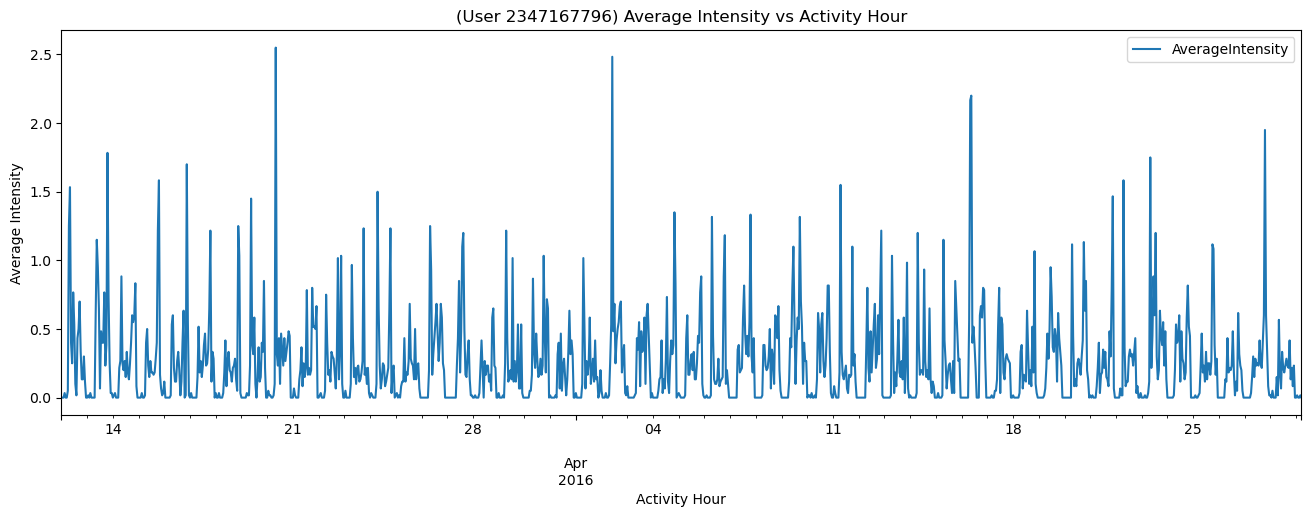

In [367]:
user_activity_hourly_df.plot(figsize=(16, 5))
plt.title(f'(User {selected_user}) Average Intensity vs Activity Hour')
plt.ylabel('Average Intensity')
plt.xlabel("Activity Hour")
plt.show()

# Adding extra features

In [368]:
user_activity_hourly_df['hour'] = user_activity_hourly_df.index.hour
user_activity_hourly_df['dayofweek'] = user_activity_hourly_df.index.dayofweek
user_activity_hourly_df['dayofmonth'] = user_activity_hourly_df.index.day
user_activity_hourly_df['isweekend'] = user_activity_hourly_df['dayofweek'] >= 5

In [369]:
user_activity_hourly_df

,AverageIntensity,hour,dayofweek,dayofmonth,isweekend
ActivityHour,,,,,
2016-03-12 00:00:00,0.000000,0,5,12,True
2016-03-12 01:00:00,0.000000,1,5,12,True
2016-03-12 02:00:00,0.000000,2,5,12,True
2016-03-12 03:00:00,0.033333,3,5,12,True
2016-03-12 04:00:00,0.000000,4,5,12,True
...,...,...,...,...,...
2016-04-29 01:00:00,0.016667,1,4,29,False
2016-04-29 02:00:00,0.000000,2,4,29,False
2016-04-29 03:00:00,0.000000,3,4,29,False


## Exploration of the new features

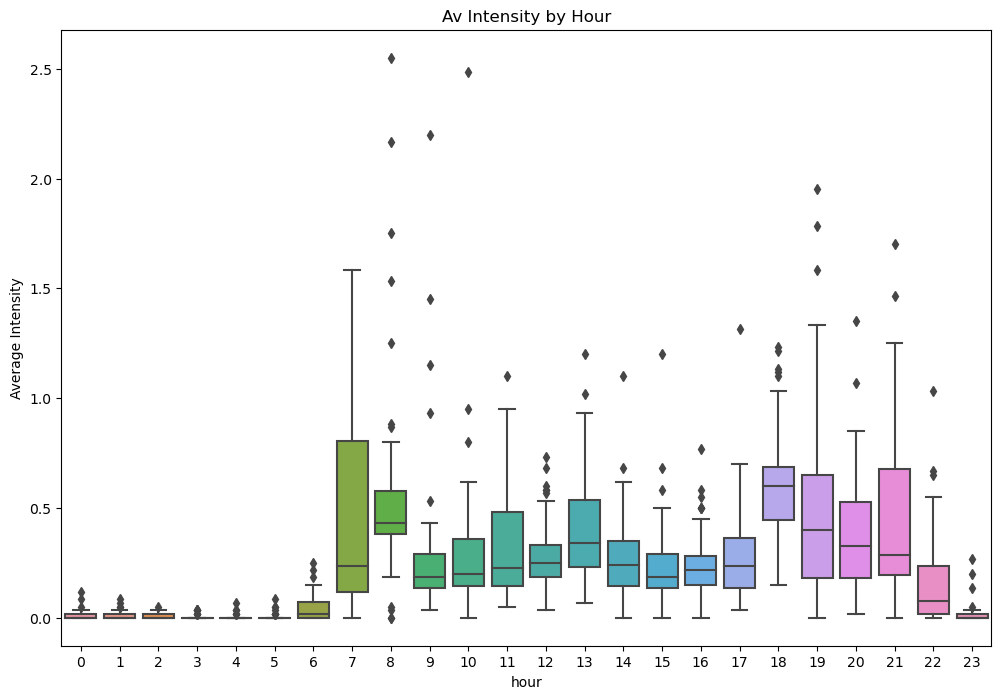

In [370]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=user_activity_hourly_df, x='hour', y='AverageIntensity')
ax.set_title('Av Intensity by Hour')
plt.ylabel('Average Intensity')
plt.show()

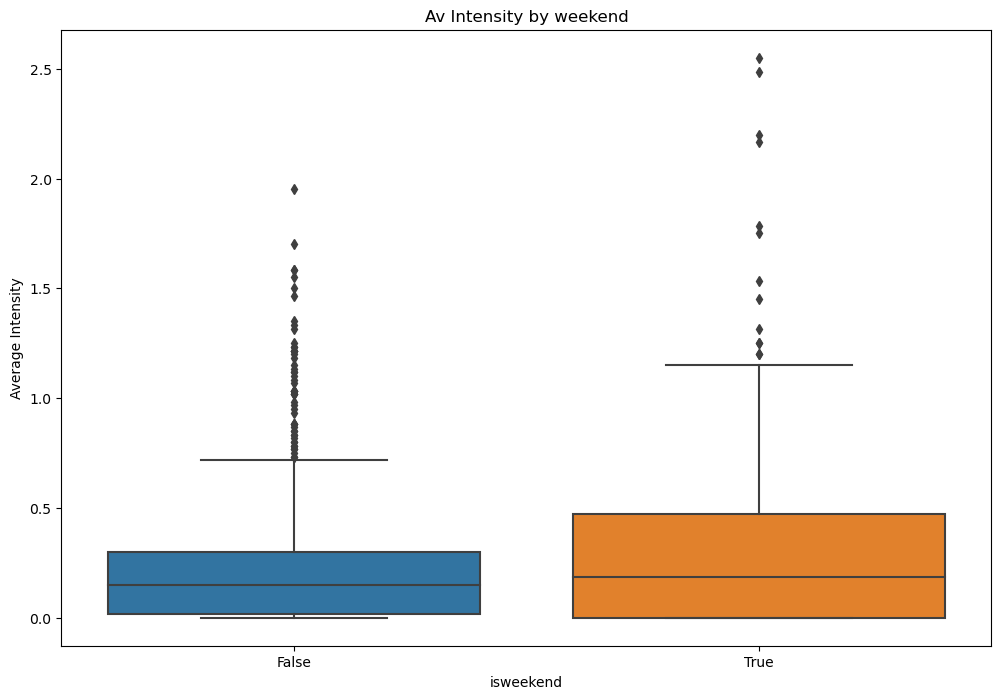

In [371]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=user_activity_hourly_df, x='isweekend', y='AverageIntensity')
ax.set_title('Av Intensity by weekend')
plt.ylabel('Average Intensity')
plt.show()

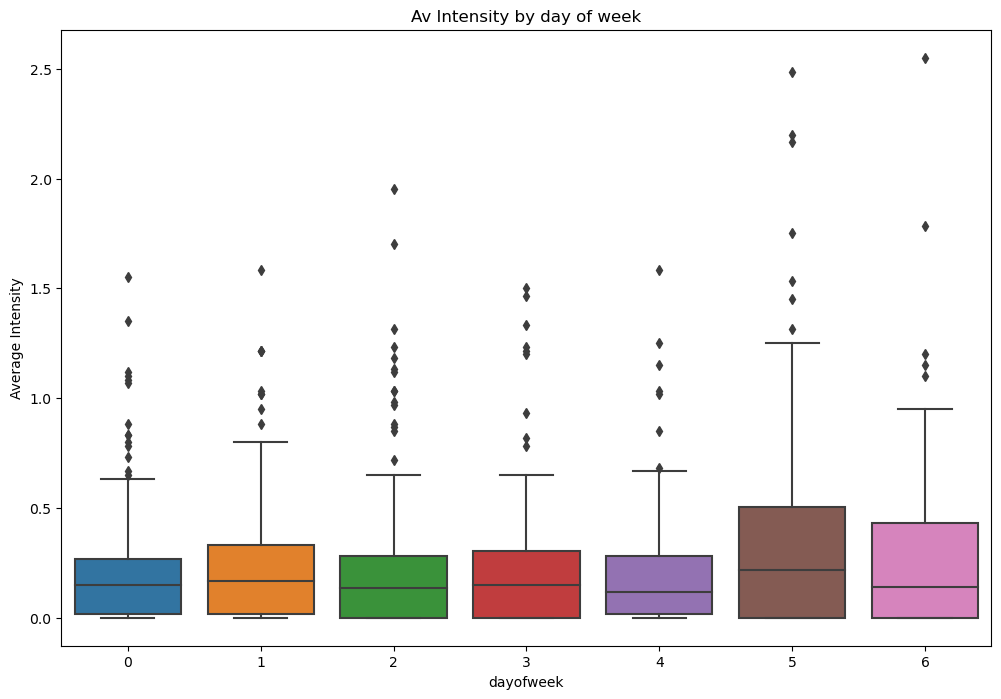

In [372]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=user_activity_hourly_df, x='dayofweek', y='AverageIntensity')
ax.set_title('Av Intensity by day of week')
plt.ylabel('Average Intensity')
plt.show()

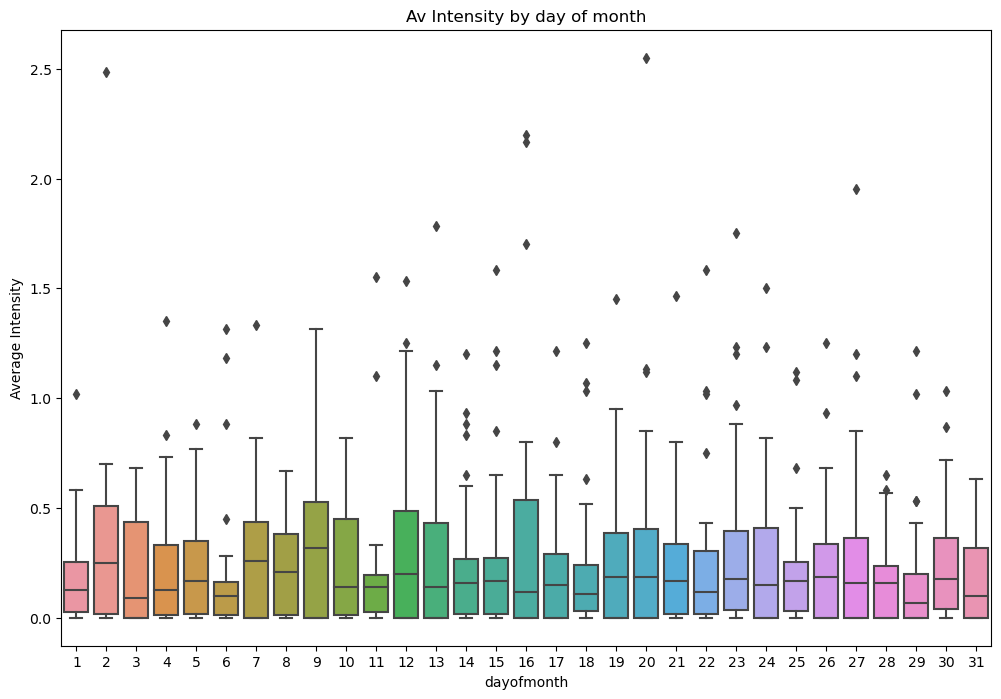

In [373]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=user_activity_hourly_df, x='dayofmonth', y='AverageIntensity')
ax.set_title('Av Intensity by day of month')
plt.ylabel('Average Intensity')
plt.show()

## Split data into train and test datasets

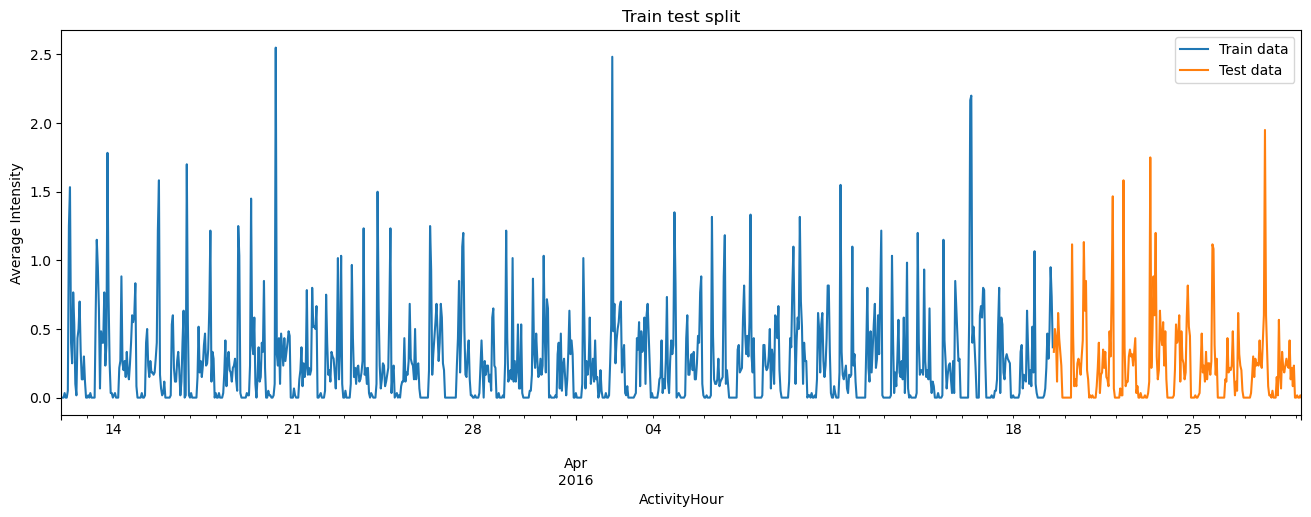

In [374]:
train_split = 0.80
train_size = int(np.round(train_split * len(user_activity_hourly_df.values)))

train_data = user_activity_hourly_df[:train_size]
test_data = user_activity_hourly_df[train_size:]

fig, ax = plt.subplots(figsize=(16,5))
train_data['AverageIntensity'].plot(ax=ax, label='Train data')
test_data['AverageIntensity'].plot(ax=ax, label='Test data')
ax.legend(['Train data', 'Test data'])

plt.title('Train test split')
plt.ylabel(f'Average Intensity')
plt.show()

## Splitting out features and targets:

In [375]:
X_cols = ['hour', 'dayofweek', 'dayofmonth', 'isweekend']
y_col = 'AverageIntensity'

X_train, y_train = train_data[X_cols], train_data[y_col]
X_test, y_test = test_data[X_cols], test_data[y_col]


# Modelling

In [376]:
# XGBoost model:
xgbr = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, early_stopping_rounds=50, max_depth=3)

# Fit the model to the training data
xgbr.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:0.41188	validation_1-rmse:0.40285
[100]	validation_0-rmse:0.29618	validation_1-rmse:0.27536
[200]	validation_0-rmse:0.27230	validation_1-rmse:0.24754
[300]	validation_0-rmse:0.26421	validation_1-rmse:0.23831
[400]	validation_0-rmse:0.25873	validation_1-rmse:0.23263
[500]	validation_0-rmse:0.25477	validation_1-rmse:0.23025
[544]	validation_0-rmse:0.25385	validation_1-rmse:0.23042


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature importance

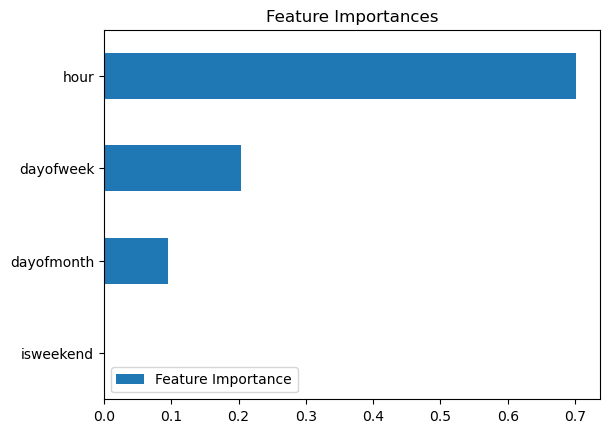

In [377]:
feature_importances = pd.DataFrame(data=xgbr.feature_importances_,
             index=xgbr.feature_names_in_,
             columns=['Feature Importance'])
feature_importances.sort_values('Feature Importance').plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# Get predictions with test set

/var/folders/jn/tpkp2dnx08592l_y59z9_f3m0000gn/T/ipykernel_40652/3699075360.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['av_intensity_pred'] = predictions


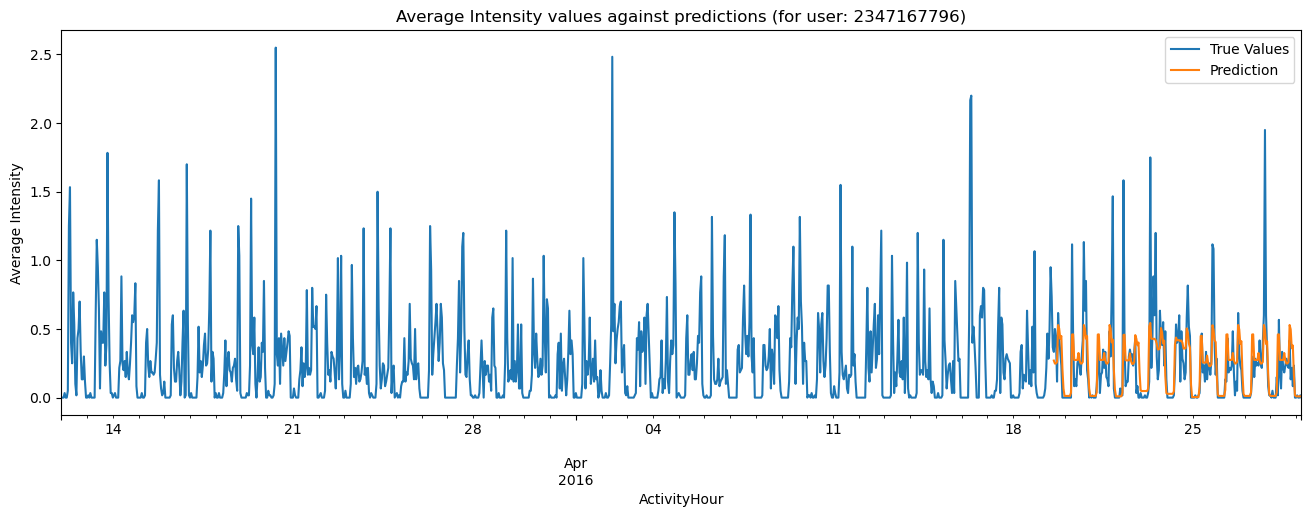

In [378]:
predictions = xgbr.predict(X_test)
test_data['av_intensity_pred'] = predictions

# combine the predictions and raw data together
user_activity_hourly_df_preds_full = user_activity_hourly_df.merge(test_data[['av_intensity_pred']], how='left', left_index=True, right_index=True)

# plot both true value and prediction lines
ax = user_activity_hourly_df_preds_full[['AverageIntensity']].plot(figsize=(16, 5))
user_activity_hourly_df_preds_full['av_intensity_pred'].plot(ax=ax)

plt.title(f'Average Intensity values against predictions (for user: {selected_user})')
plt.ylabel('Average Intensity')
plt.legend(['True Values', 'Prediction'])
plt.show()

In [380]:
test_data[['av_intensity_pred']]

,av_intensity_pred
ActivityHour,
2016-04-19 14:00:00,0.270143
2016-04-19 15:00:00,0.248230
2016-04-19 16:00:00,0.248230
2016-04-19 17:00:00,0.259631
2016-04-19 18:00:00,0.528760
...,...
2016-04-29 01:00:00,0.009393
2016-04-29 02:00:00,0.009393
2016-04-29 03:00:00,0.009393


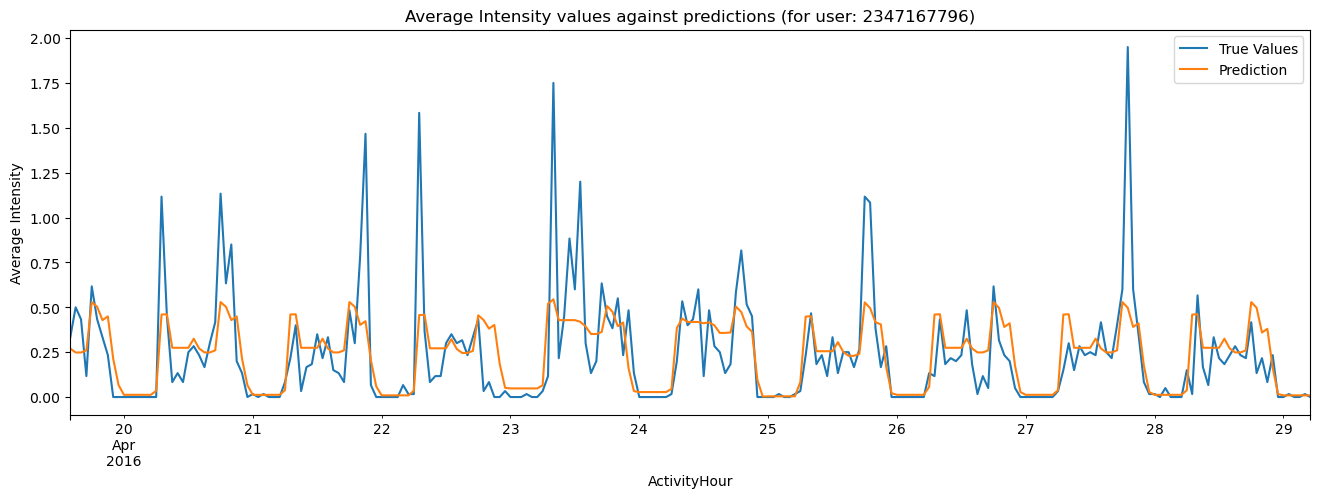

In [307]:
# combine the predictions and raw data together
user_activity_hourly_df_preds = user_activity_hourly_df.merge(test_data[['av_intensity_pred']], how='right', left_index=True, right_index=True)

# plot both true value and prediction lines
ax = user_activity_hourly_df_preds[['AverageIntensity']].plot(figsize=(16, 5))
user_activity_hourly_df_preds['av_intensity_pred'].plot(ax=ax)

plt.title(f'Average Intensity values against predictions (for user: {selected_user})')
plt.ylabel('Average Intensity')
plt.legend(['True Values', 'Prediction'])
plt.show()

In [308]:
rmse = np.sqrt(mean_squared_error(test_data['AverageIntensity'], test_data['av_intensity_pred']))
print(f'RMSE on Test dataset: {rmse:0.2f}')

RMSE on Test dataset: 0.23


In [119]:
# Note: better for comparing against models with different scales:
nrmsd = rmse / (max(test_data['AverageIntensity']) - min(test_data['AverageIntensity']))
print(f'Normalized Root-Mean-Square Deviation : {nrmsd:0.2f}')

Normalized Root-Mean-Square Deviation : 0.12


In [120]:
# extensions: hyperparameter tuning, further feature engineering, repeating the process for the other users -> worth moving out of a notebook first.